# Машинное обучение
## Лабораторная работа №2

Выполнил студент группы 15-В-2   
Пухов Артем

Вариант №40

In [8]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from scipy import interp
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
sns.set_style('darkgrid')

### 1) Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных

**Набор данных описывает характеристики вина. Научим классификатор предсказывать тип вина по этим характеристикам**

| Переменная   | Описание  | Параметры(Ключи)  | 
|--------------|--------------|-------------------|
|type|тип вина|категории: 1, 2, 3|
|alcohol|содержание алкоголя|вещественный|
|acid|кислотность| вещественный|
|ash|пепел|вещественный|
|alcalinity|щелочность|вещественный|
|magnesium|магний|вещественный|
|total phenols|количество фенолов|вещественный|
|flavanoids|флавоноиды|вещественный|
|proanthocyanins|проантоцианидины|вещественный|
|color intesity|интенсивность цвета|вещественный|
|hue|оттенок|вещественный|
|od280|od280|вещественный|
|proline|пролин|вещественный|


In [9]:
header = ['type', 'alcohol', 'acid', 'ash', 
          'alcalinity', 'magnesium', 'total phenols', 'flavanoids',
          'nonflavanoid phenols', 'proanthocyanins', 'color intensity',
          'hue', 'od280', 'proline']
df = pd.read_csv('wine.data.txt', names=header) 
df.head()

,type,alcohol,acid,ash,alcalinity,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,od280,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [10]:
print('dataset size', df.shape)
df.count()

dataset size (178, 14)


type                    178
alcohol                 178
acid                    178
ash                     178
alcalinity              178
magnesium               178
total phenols           178
flavanoids              178
nonflavanoid phenols    178
proanthocyanins         178
color intensity         178
hue                     178
od280                   178
proline                 178
dtype: int64

### 2) Удалите дубликаты строк в наборе данных

In [11]:
df = df.drop_duplicates()
print('dataset size', df.shape)
df.count()

dataset size (178, 14)


type                    178
alcohol                 178
acid                    178
ash                     178
alcalinity              178
magnesium               178
total phenols           178
flavanoids              178
nonflavanoid phenols    178
proanthocyanins         178
color intensity         178
hue                     178
od280                   178
proline                 178
dtype: int64

### 3) Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

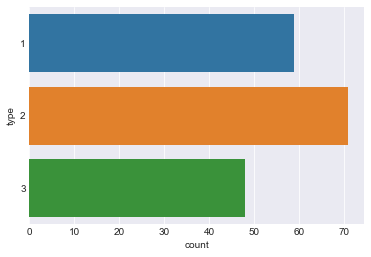

In [12]:
sns.countplot(data=df, y='type')
plt.show()

Классы не сбалансированы

### 4)  Выполните масштабирование количественных признаков

In [13]:
# выделим категориальные и числовые(количественные) признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['type', 'alcohol', 'acid', 'ash', 'alcalinity', 'magnesium', 'total phenols', 'flavanoids', 'nonflavanoid phenols', 'proanthocyanins', 'color intensity', 'hue', 'od280', 'proline']
categorial:  []


type должен быть категорилальным

In [15]:
df['type'] = df['type'].apply(lambda x: str(x))

numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']
print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['alcohol', 'acid', 'ash', 'alcalinity', 'magnesium', 'total phenols', 'flavanoids', 'nonflavanoid phenols', 'proanthocyanins', 'color intensity', 'hue', 'od280', 'proline']
categorial:  ['type']


In [16]:
# нормализуем
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,type,alcohol,acid,ash,alcalinity,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,od280,proline
0,1,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,1,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,1,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,1,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


### 5) Выполните замену категориальных признаков

In [22]:
lb_make = LabelEncoder() 
df["type"] = lb_make.fit_transform(df["type"])
df.head()

,type,alcohol,acid,ash,alcalinity,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,od280,proline
0,0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


### 6) Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

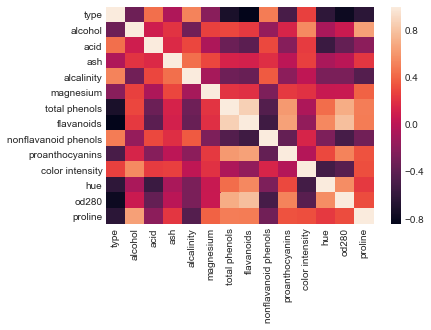

In [23]:
df_corr = df.corr()
sns.heatmap(df_corr)
plt.show()

### 7)   Заполните пропущенные значения в данных

In [24]:
print('dataset size', df.shape)
df.count()

dataset size (178, 14)


type                    178
alcohol                 178
acid                    178
ash                     178
alcalinity              178
magnesium               178
total phenols           178
flavanoids              178
nonflavanoid phenols    178
proanthocyanins         178
color intensity         178
hue                     178
od280                   178
proline                 178
dtype: int64

### 8)	Решите поставленную задачу классификации в соответствии с заданием
- классификатор K ближайших соседей (по радиусу)
- логический классификатор (бинарное решающее дерево)

In [27]:
# разделим полученные данные на данные для обучения и теста
X = np.array(df.drop('type', axis=1))
y = np.array(df['type']) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

In [28]:
# найдем оптимальный радиус для классификатора ближайших соседей
rnc = RadiusNeighborsClassifier(outlier_label=3)

params = {'radius': np.arange(0, 10, 0.1)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, '\t at radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label=3, radius=best_radius)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score: 0.9887640449438202 	 at radius: 0.9
test score:  0.910112359551


In [30]:
#найдем оптимальные глубину и количества учитываемых параметров для классификатора решающее дерево
dtc = DecisionTreeClassifier()

params = {'max_depth': list(range(1,5)), 'max_features': list(range(1,5))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 0.9213483146067416 	 at features number: 4 	 at depth: 4
test score:  0.865168539326


In [31]:
from sklearn.metrics import accuracy_score
classifier = RadiusNeighborsClassifier(radius=1.1, n_jobs=-1, outlier_label=3).fit(X_train, y_train)
pred = classifier.predict(X_test)
accuracy_score(y_test, pred)
pred = classifier.radius_neighbors(X_test)[0]
y_test = label_binarize(y_test, classes=[0, 1, 2])
for i in range(len(pred)):
    pred[:][i] = min(pred[:][i]), max(pred[:][i]), np.mean(pred[:][i])
pred[:][73]

(0.3013538903431508, 1.0978006859598604, 0.65805343115833226)

In [32]:
class MyRadiusNeighborsClassifier(RadiusNeighborsClassifier):
        
    def predict_proba(self, X_test, X_train, y_train):
        '''
        
        General description. 
        Determines the probability that a test instance matching a class.
        
        Algorithm. 
        We'll go through the zero radius to the double classifier radius
        with the elementary step(dr). If an instance lies along the:
        * Zero raduis+dr - corresponds 100%
        * Classifier raduis+dr - corresponds 50%
        * Double classifier raduis+dr and beyond it - corresponds 0%
        There are intermediate values of percents. Each step corresponds
        to its own percentage value. If predicted instance changes its 
        class, this instance belongs to the current radius and it is 
        assigned the appropriate percentage. 
        
        fit method built-in
        '''
        runs = 25
        dr = (2*self.radius/runs)    
        
        radiuses = [dr*i for i in range(runs)]  
        percentage = [i/runs for i in range(runs)]
        percentage = sorted(percentage, reverse=True)
        probas = np.ndarray((len(y_test),3), dtype=np.float)
        for i in range(len(probas)):
            probas[i] = [0, 1, 2]
        
        for i, radius in enumerate(radiuses):
            if i==0:
                rnc_temp = RadiusNeighborsClassifier(radius, outlier_label=3)
                predict_first = rnc_temp.fit(X_train, y_train).predict(X_test)
                continue
            else:
                predict_second = predict_first
                rnc_tmp = RadiusNeighborsClassifier(radius, outlier_label=3)
                predict_first = rnc_tmp.fit(X_train, y_train).predict(X_test)
        
            for j, (p1, p2) in enumerate(zip(predict_first, predict_second)):
                if p1!=p2:
                    probas[j,0] = percentage[i]
                    probas[j,1] = 1-probas[j,0]
                
        return probas

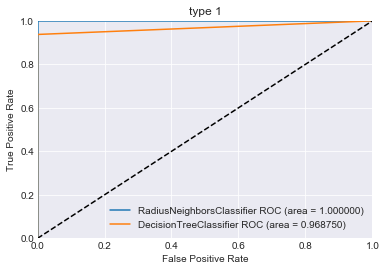

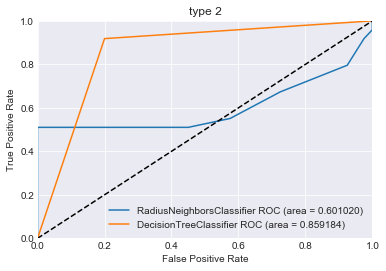

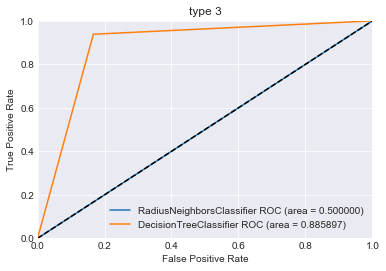

In [41]:
mrnc = MyRadiusNeighborsClassifier(outlier_label=3, radius=best_radius)
probas_mrnc0 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,0], -probas_mrnc0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,0], -probas_dtc0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))  

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('type 1')
plt.show()

mrnc = MyRadiusNeighborsClassifier(outlier_label=3, radius=best_radius)
probas_mrnc1 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,1], -probas_mrnc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=4, max_features=2)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,1], -probas_dtc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))  

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('type 2')
plt.show()

mrnc = MyRadiusNeighborsClassifier(outlier_label=3, radius=best_radius)
probas_mrnc2 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,2], -probas_mrnc0[:,2])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=4, max_features=2)
probas_dtc2 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,2], -probas_dtc0[:,2])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))  

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('type 3')
plt.show()

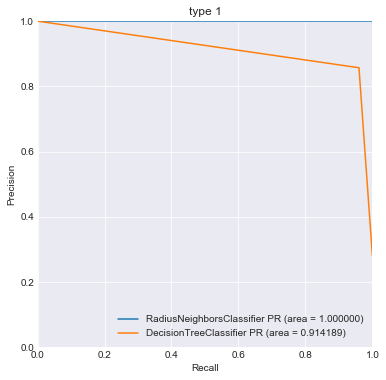

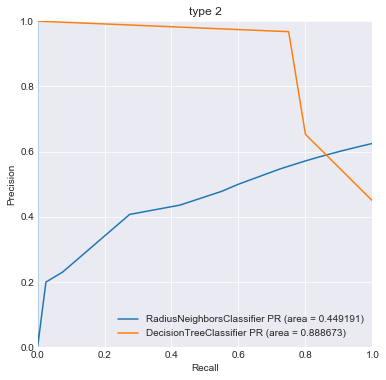

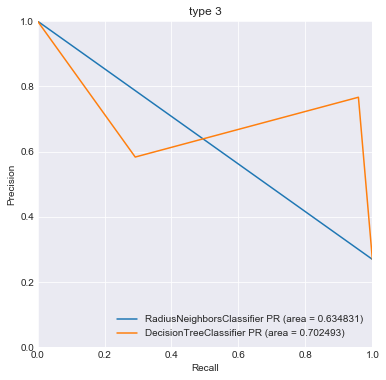

In [44]:
plt.figure(figsize=(6,6))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test[:,0], probas_mrnc1[:,0])
aps_mrnc1 = average_precision_score(y_test[:,0],probas_mrnc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test[:,0], probas_dtc1[:,0])
aps_dtc1 = average_precision_score(y_test[:,0],probas_dtc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('type 1')
plt.show()

plt.figure(figsize=(6,6))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test[:,1], probas_mrnc1[:,1])
aps_mrnc1 = average_precision_score(y_test[:,1],probas_mrnc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test[:,1], probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test[:,1],probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('type 2')
plt.show()

plt.figure(figsize=(6,6))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test[:,2], probas_mrnc1[:,2])
aps_mrnc1 = average_precision_score(y_test[:,2],probas_mrnc1[:,2])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test[:,2], probas_dtc1[:,2])
aps_dtc1 = average_precision_score(y_test[:,2],probas_dtc1[:,2])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('type 3')
plt.show()

### 9)	Сравните кривые для классификаторов, указанных в задании, сделайте выводы
Классификаторы дерево принятия решений и k ближайших соседей(по радиусу) имеют примерно одинаковые показатели качества относительно PR и ROC кривых. Данные классификаторы справляются со своей задачей, так как их точность 0.9 ~ 0.7.